In [ ]:
"""
In this example we make use of advanced RAG to answer users question on a specific knowlegde base -> using LangChain
"""

In [1]:
from tqdm import tqdm
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

In [2]:
# Loading the knowledge base
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [3]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

100%|██████████| 2647/2647 [00:00<00:00, 17706.63it/s]


In [ ]:
# Retrieval - Embeddings
# The snippet size are called chunk size which is how the data is stored and retrieved.
# We need to make sure that the top_k is tuned towards relavancy vs random documents to have a consistent response.

In [ ]:
# Chunking notebook example - which describes many chunking strategies
# https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb

In [4]:
# Using Langchains recursive character splitter for chunking
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

CHUNK_SIZE = 8000

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=int(0.1 * CHUNK_SIZE),  # The number of characters to overlap between chunks - 1/10 (chunk_size)
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [5]:
# Now we have processed the documents to arbitracy size but under chunk_size, lets verify this

for chunked_doc in docs_processed[:10]:
    print(len(chunked_doc.page_content))

2011
4888
7263
7768
6263
696
2907
2919
1606
3555


In [ ]:
# Next we will embed these into a vector database, since that would transform these aribitrary chunks into the embedding space which will make sense for the
# retrievel in that space.

# we set the max length of the embedding space to max_seq_length

In [6]:
from sentence_transformers import SentenceTransformer

# getting the maximum sentence length
print(SentenceTransformer("jinaai/jina-embeddings-v2-base-en").max_seq_length)

/Users/riaz/miniconda3/envs/cookbook/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.

8192


100%|██████████| 4647/4647 [00:35<00:00, 130.64it/s]


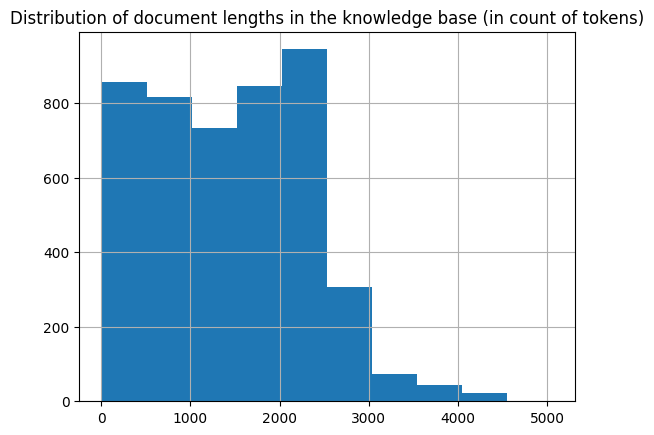

In [7]:
from transformers import AutoTokenizer

# Lets find out the max token size using the embedding model for the chunk_size
# if the max_token_length is < chunk_size, we need to increase the chunk_size or vise-versa
tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2-base-en", use_fast=False)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [8]:
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

In [9]:
len(docs_processed)

4647

In [17]:
# Note: this will not work on a Macbook effectively

from langchain_community.vectorstores.utils import DistanceStrategy

EMBEDDING_MODEL_NAME = "jinaai/jina-embeddings-v2-base-en"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=False,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True, "batch_size": 5},
    show_progress=True
)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

In [24]:
#!pip install pacmap datasets langchain-community ragatouille faiss-cpu plotly openpyxl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 36.8 MB/s eta 0:00:0000:0100:01


In [18]:
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

Batches:   0%|          | 0/930 [00:00<?, ?it/s]

In [19]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/Users/riaz/miniconda3/envs/cookbook/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [26]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [27]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


==================================Top document==================================
Gradio Demo: filter_records


```
!pip install -q gradio 
```


```
import gradio as gr


def filter_records(records, gender):
    return records[records["gender"] == gender]


demo = gr.Interface(
    filter_records,
    [
        gr.Dataframe(
            headers=["name", "age", "gender"],
            datatype=["str", "number", "str"],
            row_count=5,
            col_count=(3, "fixed"),
        ),
        gr.Dropdown(["M", "F", "O"]),
    ],
    "dataframe",
    description="Enter gender as 'M', 'F', or 'O' for other.",
)

if __name__ == "__main__":
    demo.launch()

```
==================================Metadata==================================
{'source': 'gradio-app/gradio/blob/main/demo/filter_records/run.ipynb', 'start_index': 1}


In [30]:
user_query = "Access HF Hub?"
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Access HF Hub?'...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


==================================Top document==================================
Security Policy

## Reporting a Vulnerability

If you discover a security vulnerability, we would be very grateful if you could email us at team@gradio.app. This is the preferred approach instead of opening a public issue. We take all vulnerability reports seriously, and will work to patch the vulnerability immediately. Whenever possible, we will credit the person or people who report the security vulnerabilities after it has been patched.
==================================Metadata==================================
{'source': 'gradio-app/gradio/blob/main/SECURITY.md', 'start_index': 1}
